In [3]:
!pip install wget

In [14]:
import wget

url_template = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt"
for date in ['160206', '160213', '160220', '160227', '160305']:
    url = url_template % date
    wget.download(url, out='data/')
    print(date, 'file downloaded')

160206 file downloaded
160213 file downloaded
160220 file downloaded
160227 file downloaded
160305 file downloaded


In [5]:
import csv, glob
from collections import defaultdict

def read_csv(csv_file_name):
    turnstile_to_count_reading = defaultdict(list)
    with open(csv_file_name, 'r') as csv_file:
        mta_reader = csv.reader(csv_file)
        for i, row in enumerate(mta_reader):
            if i == 0:
                continue
                
            turnstile_info = tuple(row[:4])
            count_reading = row[4:]
            turnstile_to_count_reading[turnstile_info].append(count_reading)
            
    return turnstile_to_count_reading

In [28]:
weekly_data_dicts = [read_csv(csvfile) for csvfile in glob.glob('data/turnstile_*.txt')]

In [27]:
sample_dict = list(weekly_data_dicts[0].items())[:1]
sample_dict

[(('N300', 'R113', '01-00-04', '7 AV'),
  [['BDE',
    'IND',
    '01/30/2016',
    '00:00:00',
    'REGULAR',
    '1833169803',
    '0772199762                                                 '],
   ['BDE',
    'IND',
    '01/30/2016',
    '04:00:00',
    'REGULAR',
    '1833169907',
    '0772199791                                                 '],
   ['BDE',
    'IND',
    '01/30/2016',
    '08:00:00',
    'REGULAR',
    '1833169944',
    '0772199845                                                 '],
   ['BDE',
    'IND',
    '01/30/2016',
    '12:00:00',
    'REGULAR',
    '1833170049',
    '0772199961                                                 '],
   ['BDE',
    'IND',
    '01/30/2016',
    '16:00:00',
    'REGULAR',
    '1833170247',
    '0772200108                                                 '],
   ['BDE',
    'IND',
    '01/30/2016',
    '20:00:00',
    'REGULAR',
    '1833170497',
    '0772200240                                                 '],
   ['BDE',
    'IN

In [31]:
from datetime import datetime
from dateutil.parser import parse

def convert_week_data_to_time_series(week_data_dict):
    turnstile_to_time_series = defaultdict(list)
    for i, (turnstile, row_data) in enumerate(week_data_dict.items()):
        if i % 200 == 0:
            print('Processing turnstile', turnstile)
        for lines, division, datestr, timestr, event, cum_entries, cum_exits in row_data:
            timestamp = parse('%sT%s' % (datestr, timestr))
            turnstile_to_time_series[turnstile].append([timestamp, int(cum_entries)])
            
    return turnstile_to_time_series

In [32]:
weekly_time_series = list(map(convert_week_data_to_time_series, weekly_data_dicts))

Processing turnstile ('N300', 'R113', '01-00-04', '7 AV')
Processing turnstile ('C017', 'R455', '00-00-02', '25 ST')
Processing turnstile ('N203', 'R195', '00-05-00', '161/YANKEE STAD')
Processing turnstile ('C001', 'R108', '01-00-01', 'BOROUGH HALL')
Processing turnstile ('R532', 'R328', '00-00-01', 'METS-WILLETS PT')
Processing turnstile ('N051', 'R084', '02-03-03', '59 ST COLUMBUS')
Processing turnstile ('A011', 'R080', '01-00-05', '57 ST-7 AV')
Processing turnstile ('R135', 'R031', '01-00-02', '34 ST-PENN STA')
Processing turnstile ('R512', 'R092', '00-03-01', 'BROADWAY')
Processing turnstile ('A013', 'R081', '01-03-00', '49 ST')
Processing turnstile ('A058', 'R001', '01-00-03', 'WHITEHALL S-FRY')
Processing turnstile ('N340', 'R115', '00-00-02', '169 ST')
Processing turnstile ('R605', 'R456', '00-03-00', 'HOYT ST')
Processing turnstile ('N137', 'R354', '00-00-02', '104 ST')
Processing turnstile ('PTH08', 'R540', '00-01-06', 'PATH WTC')
Processing turnstile ('N100', 'R252', '00-00-

In [101]:
sample_turnstile_to_time_series = list(weekly_time_series[0].items())[:2]
sample_turnstile_to_time_series

[(('N300', 'R113', '01-00-04', '7 AV'),
  [[datetime.datetime(2016, 1, 30, 0, 0), 1833169803],
   [datetime.datetime(2016, 1, 30, 4, 0), 1833169907],
   [datetime.datetime(2016, 1, 30, 8, 0), 1833169944],
   [datetime.datetime(2016, 1, 30, 12, 0), 1833170049],
   [datetime.datetime(2016, 1, 30, 16, 0), 1833170247],
   [datetime.datetime(2016, 1, 30, 20, 0), 1833170497],
   [datetime.datetime(2016, 1, 31, 0, 0), 1833170719],
   [datetime.datetime(2016, 1, 31, 8, 0), 1833170873],
   [datetime.datetime(2016, 1, 31, 12, 0), 1833170973],
   [datetime.datetime(2016, 1, 31, 16, 0), 1833171166],
   [datetime.datetime(2016, 1, 31, 20, 0), 1833171495],
   [datetime.datetime(2016, 2, 1, 0, 0), 1833171664],
   [datetime.datetime(2016, 2, 1, 4, 0), 1833171712],
   [datetime.datetime(2016, 2, 1, 8, 0), 1833171794],
   [datetime.datetime(2016, 2, 1, 12, 0), 1833172173],
   [datetime.datetime(2016, 2, 1, 16, 0), 1833172594],
   [datetime.datetime(2016, 2, 1, 20, 0), 1833173700],
   [datetime.datetime(

In [118]:
def combine_multiple_weeks_into_single_high_res_timeseries(weekly_time_series):
    combined_time_series = defaultdict(list)
    for turnstile_to_weeklong_time_series in weekly_time_series:
        for turnstile, weeklong_time_series in turnstile_to_weeklong_time_series.items():
            combined_time_series[turnstile] += weeklong_time_series
            
    # It's already sorted due to the nature of the files
    return combined_time_series


turnstile_to_full_time_series = combine_multiple_weeks_into_single_high_res_timeseries(weekly_time_series)

In [119]:
sample_turnstile_to_full_time_series = list(turnstile_to_full_time_series.items())[:2]
sample_turnstile_to_full_time_series

[(('N300', 'R113', '01-00-04', '7 AV'),
  [[datetime.datetime(2016, 1, 30, 0, 0), 1833169803],
   [datetime.datetime(2016, 1, 30, 4, 0), 1833169907],
   [datetime.datetime(2016, 1, 30, 8, 0), 1833169944],
   [datetime.datetime(2016, 1, 30, 12, 0), 1833170049],
   [datetime.datetime(2016, 1, 30, 16, 0), 1833170247],
   [datetime.datetime(2016, 1, 30, 20, 0), 1833170497],
   [datetime.datetime(2016, 1, 31, 0, 0), 1833170719],
   [datetime.datetime(2016, 1, 31, 8, 0), 1833170873],
   [datetime.datetime(2016, 1, 31, 12, 0), 1833170973],
   [datetime.datetime(2016, 1, 31, 16, 0), 1833171166],
   [datetime.datetime(2016, 1, 31, 20, 0), 1833171495],
   [datetime.datetime(2016, 2, 1, 0, 0), 1833171664],
   [datetime.datetime(2016, 2, 1, 4, 0), 1833171712],
   [datetime.datetime(2016, 2, 1, 8, 0), 1833171794],
   [datetime.datetime(2016, 2, 1, 12, 0), 1833172173],
   [datetime.datetime(2016, 2, 1, 16, 0), 1833172594],
   [datetime.datetime(2016, 2, 1, 20, 0), 1833173700],
   [datetime.datetime(

In [120]:
# Ignore January, March, weekends and 2016 NYC holidays (Feb 12th and 15th).

removed = 0
for turnstile, turnstile_data in turnstile_to_full_time_series.items():
    # iterate over a copy of the list in order to be able to remove items from the original
    for timestamp, cum_entries in list(turnstile_data):
        feb_nyc_holidays = [12, 15]
        if timestamp.month != 2 or timestamp.weekday() >= 5 or timestamp.day in feb_nyc_holidays:
            if not (timestamp.month == 1 and timestamp.day == 31:
                # leave the last of january in order to be able to make the cumulative count
                turnstile_data.remove([timestamp, cum_entries])
                removed = removed + 1

print(removed)

414034


In [121]:
sample_turnstile_to_full_time_series = list(turnstile_to_full_time_series.items())[:2]
sample_turnstile_to_full_time_series

[(('N300', 'R113', '01-00-04', '7 AV'),
  [[datetime.datetime(2016, 1, 31, 0, 0), 1833170719],
   [datetime.datetime(2016, 1, 31, 8, 0), 1833170873],
   [datetime.datetime(2016, 1, 31, 12, 0), 1833170973],
   [datetime.datetime(2016, 1, 31, 16, 0), 1833171166],
   [datetime.datetime(2016, 1, 31, 20, 0), 1833171495],
   [datetime.datetime(2016, 2, 1, 0, 0), 1833171664],
   [datetime.datetime(2016, 2, 1, 4, 0), 1833171712],
   [datetime.datetime(2016, 2, 1, 8, 0), 1833171794],
   [datetime.datetime(2016, 2, 1, 12, 0), 1833172173],
   [datetime.datetime(2016, 2, 1, 16, 0), 1833172594],
   [datetime.datetime(2016, 2, 1, 20, 0), 1833173700],
   [datetime.datetime(2016, 2, 2, 0, 0), 1833173990],
   [datetime.datetime(2016, 2, 2, 4, 0), 1833174033],
   [datetime.datetime(2016, 2, 2, 8, 0), 1833174124],
   [datetime.datetime(2016, 2, 2, 12, 0), 1833174506],
   [datetime.datetime(2016, 2, 2, 16, 0), 1833174954],
   [datetime.datetime(2016, 2, 2, 20, 0), 1833176092],
   [datetime.datetime(2016, 

In [122]:
from itertools import groupby

def count_within_normal_bounds(count):
    if count is None:
        return True
    else:
        return 10000 > count >= 0

def convert_time_series_to_daily(high_res_time_series):
    daily_time_series = []
    
    def day_of_timestamp(time_series_entry):
        timestamp, tot_entries = time_series_entry
        return timestamp.date()
    
    # groupby() requires data to be sorted. It is sorted already here.
    count_on_previous_day = None
    for day, entries_on_this_day in groupby(high_res_time_series, key=day_of_timestamp):
        # get the maximum cumulative count among the entries on this day
        cum_entry_count_on_day = max([count for time, count in entries_on_this_day])
        # skip the first entry if we don't know the previous day
        if count_on_previous_day is None:
            daily_entries = None
        else:
            daily_entries = cum_entry_count_on_day - count_on_previous_day
        # Save today's count for tomorrow's calculation
        count_on_previous_day = cum_entry_count_on_day
        # Only append if the cumulative increased. Otherwise there is something wrong in the data
        # skip with a warning
        if count_within_normal_bounds(daily_entries):
            daily_time_series.append((day, daily_entries))
        else:
            print('WARNING. Abnormal entry count found on day %s: %s' % (day, daily_entries))
            daily_time_series.append((day, None))

    return daily_time_series


def convert_turnstile_to_high_res_time_series_to_daily(turnstile_to_time_series):
    turnstile_to_daily_time_series = {}
    for i, (turnstile, time_series) in enumerate(turnstile_to_time_series.items()):
        print('Processing turnstile', turnstile)
        turnstile_to_daily_time_series[turnstile] = convert_time_series_to_daily(time_series)
    return turnstile_to_daily_time_series


turnstile_to_daily_time_series = convert_turnstile_to_high_res_time_series_to_daily(turnstile_to_full_time_series)

Processing turnstile ('N300', 'R113', '01-00-04', '7 AV')
Processing turnstile ('N030', 'R333', '00-00-00', '116 ST')
Processing turnstile ('PTH12', 'R542', '00-04-02', 'TWENTY THIRD ST')
WARNING. Abnormal entry count found on day 2016-02-24: -7518
Processing turnstile ('N505', 'R022', '02-00-02', '34 ST-HERALD SQ')
Processing turnstile ('R626', 'R062', '00-05-00', 'CROWN HTS-UTICA')
Processing turnstile ('N196', 'R285', '00-00-01', 'FAR ROCKAWAY')
Processing turnstile ('R530', 'R310', '00-00-04', '111 ST')
Processing turnstile ('B020', 'R263', '00-05-00', 'AVENUE H')
Processing turnstile ('N080', 'R138', '00-00-01', 'W 4 ST-WASH SQ')
Processing turnstile ('R312', 'R405', '00-00-01', 'JACKSON AV')
Processing turnstile ('R182', 'R035', '00-03-00', '168 ST')
Processing turnstile ('H030', 'R266', '01-00-00', 'HALSEY ST')
Processing turnstile ('R196', 'R306', '00-00-02', '238 ST')
Processing turnstile ('R237', 'R046', '01-00-06', 'GRD CNTRL-42 ST')
Processing turnstile ('N329', 'R201', '00

In [123]:
turnstile_to_daily_time_series[('N300', 'R113', '01-00-04', '7 AV')]

[(datetime.date(2016, 1, 31), None),
 (datetime.date(2016, 2, 1), 2205),
 (datetime.date(2016, 2, 2), 2392),
 (datetime.date(2016, 2, 3), 2570),
 (datetime.date(2016, 2, 4), 2551),
 (datetime.date(2016, 2, 5), 2444),
 (datetime.date(2016, 2, 8), 3690),
 (datetime.date(2016, 2, 9), 2235),
 (datetime.date(2016, 2, 10), 2394),
 (datetime.date(2016, 2, 11), 2510),
 (datetime.date(2016, 2, 16), 7517),
 (datetime.date(2016, 2, 17), 2366),
 (datetime.date(2016, 2, 18), 2263),
 (datetime.date(2016, 2, 19), 2417),
 (datetime.date(2016, 2, 22), 4181),
 (datetime.date(2016, 2, 23), 2397),
 (datetime.date(2016, 2, 24), 2455),
 (datetime.date(2016, 2, 25), 2440),
 (datetime.date(2016, 2, 26), 2280),
 (datetime.date(2016, 2, 29), 3564)]

In [124]:
from collections import Counter

def booth_of_a_time_series_item(item):
    turnstile, time_series = item
    control_area, unit, device_id, station = turnstile
    return (control_area, unit, station)

def reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series):
    turnstile_time_series_items = sorted(turnstile_to_daily_time_series.items())
    booth_to_time_series = {}
    
    for booth, item_list_of_booth in groupby(turnstile_time_series_items, key=booth_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_booth:
            for day, count in time_series:
                if count is not None:
                    daily_counter[day] += count
        
        booth_to_time_series[booth] = sorted(daily_counter.items())
        
    return booth_to_time_series

booth_to_daily_time_series = reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series)

In [128]:
booth_to_daily_time_series[('N300', 'R113', '7 AV')]

[(datetime.date(2016, 2, 1), 6519),
 (datetime.date(2016, 2, 2), 7243),
 (datetime.date(2016, 2, 3), 7688),
 (datetime.date(2016, 2, 4), 7365),
 (datetime.date(2016, 2, 5), 7176),
 (datetime.date(2016, 2, 8), 11344),
 (datetime.date(2016, 2, 9), 6965),
 (datetime.date(2016, 2, 10), 7591),
 (datetime.date(2016, 2, 11), 7714),
 (datetime.date(2016, 2, 16), 23320),
 (datetime.date(2016, 2, 17), 7322),
 (datetime.date(2016, 2, 18), 7378),
 (datetime.date(2016, 2, 19), 7483),
 (datetime.date(2016, 2, 22), 13378),
 (datetime.date(2016, 2, 23), 7403),
 (datetime.date(2016, 2, 24), 7632),
 (datetime.date(2016, 2, 25), 7572),
 (datetime.date(2016, 2, 26), 7422),
 (datetime.date(2016, 2, 29), 11361)]

In [129]:
def station_of_a_booth(booth):
    control_area, unit, station = booth
    return station

def station_of_a_time_series_item(item):
    booth, time_series = item
    return station_of_a_booth(booth)

def reduce_booth_time_series_to_stations(booth_to_daily_time_series):
    booth_time_series_items = sorted(booth_to_daily_time_series.items())
    station_to_time_series = {}
    for station, item_list_of_station in groupby(booth_time_series_items,
                                             key=station_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_station:
            for day, count in time_series:
                daily_counter[day] += count
        station_to_time_series[station] = sorted(daily_counter.items())
    return station_to_time_series


station_to_daily_time_series = reduce_booth_time_series_to_stations(booth_to_daily_time_series)

In [130]:
station_to_daily_time_series['7 AV']

[(datetime.date(2016, 2, 1), 11696),
 (datetime.date(2016, 2, 2), 12941),
 (datetime.date(2016, 2, 3), 13104),
 (datetime.date(2016, 2, 4), 13131),
 (datetime.date(2016, 2, 5), 12552),
 (datetime.date(2016, 2, 8), 25172),
 (datetime.date(2016, 2, 9), 12738),
 (datetime.date(2016, 2, 10), 13036),
 (datetime.date(2016, 2, 11), 12954),
 (datetime.date(2016, 2, 16), 12473),
 (datetime.date(2016, 2, 17), 10949),
 (datetime.date(2016, 2, 18), 11009),
 (datetime.date(2016, 2, 19), 10545),
 (datetime.date(2016, 2, 22), 25132),
 (datetime.date(2016, 2, 23), 12567),
 (datetime.date(2016, 2, 24), 12719),
 (datetime.date(2016, 2, 25), 12625),
 (datetime.date(2016, 2, 26), 12370),
 (datetime.date(2016, 2, 29), 25311)]

In [163]:
feb_business_days = len(station_to_daily_time_series['7 AV'])

def station_time_series_item_to_station_avg_traffic(item):
    station, time_series = item
    avg_traffic = sum([count for day, count in time_series]) // feb_business_days
    return avg_traffic, station

traffic = list(map(station_time_series_item_to_station_avg_traffic, station_to_daily_time_series.items()))
traffic_report = sorted(traffic_report, reverse=True)

for avg_traffic, station in sorted(traffic_report, reverse=True)[:30]:
    print('{:<18} {}'.format(station, avg_traffic))

GRD CNTRL-42 ST    158625
42 ST-PORT AUTH    112739
34 ST-PENN STA     107514
TIMES SQ-42 ST     93595
34 ST-HERALD SQ    87825
47-50 STS ROCK     71111
FLUSHING-MAIN      70011
86 ST              67614
59 ST              59147
JKSN HT-ROOSVLT    58594
PATH WTC           54862
JAY ST-METROTEC    51762
LEXINGTON AV/53    51369
W 4 ST-WASH SQ     51012
72 ST              49478
42 ST-BRYANT PK    48248
BOROUGH HALL       45425
68ST-HUNTER CO     43720
ATL AV-BARCLAY     42502
77 ST              40686
33 ST              39430
JAMAICA CENTER     39196
BOWLING GREEN      38956
23 ST              35203
CROWN HTS-UTICA    34864
14 ST-UNION SQ     34546
KEW GARDENS        33808
FOREST HILLS 71    33785
49 ST              33092
50 ST              32767


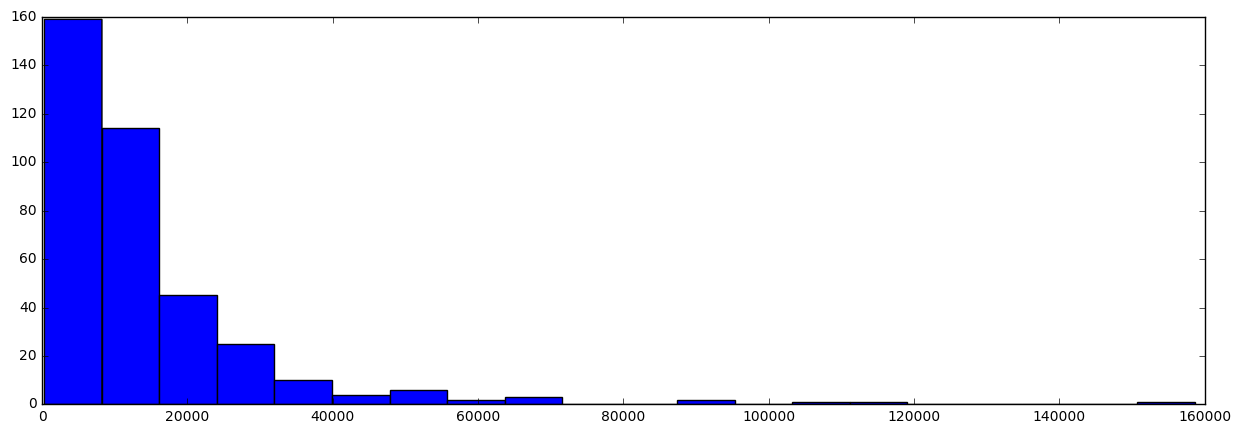

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

avg_ridership_counts = [ridership for ridership, station in traffic_report]
plt.figure(figsize=(15, 5))
hist = plt.hist(avg_ridership_counts, bins=20)

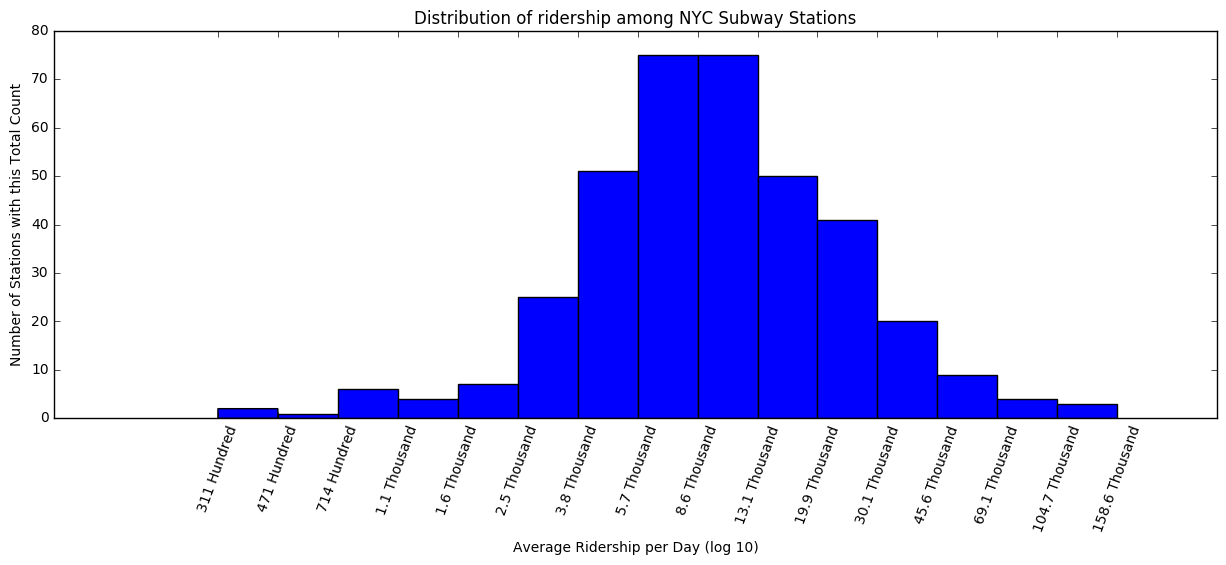

In [156]:
import math

log_counts = []

for count in avg_ridership_counts:
    try:
        log_result = math.log10(count)
    except:
        pass
    
    log_counts.append(log_result)
    
plt.figure(figsize=(15, 5))
n, bins, patches = hist = plt.hist(log_counts, bins=15)

def log_count_to_label(log_count):
    if log_count <= 3:
        return '{0:.0f} Hundred'.format(10 ** (log_count))
    else:
        return '{0:.1f} Thousand'.format(10 ** (log_count-3))

tick_labels = map(log_count_to_label, bins)
ticks = plt.xticks(bins, tick_labels, rotation=70)
plt.xlabel('Average Ridership per Day (log 10)')
plt.ylabel('Number of Stations with this Total Count')
plt.title('Distribution of ridership among NYC Subway Stations')

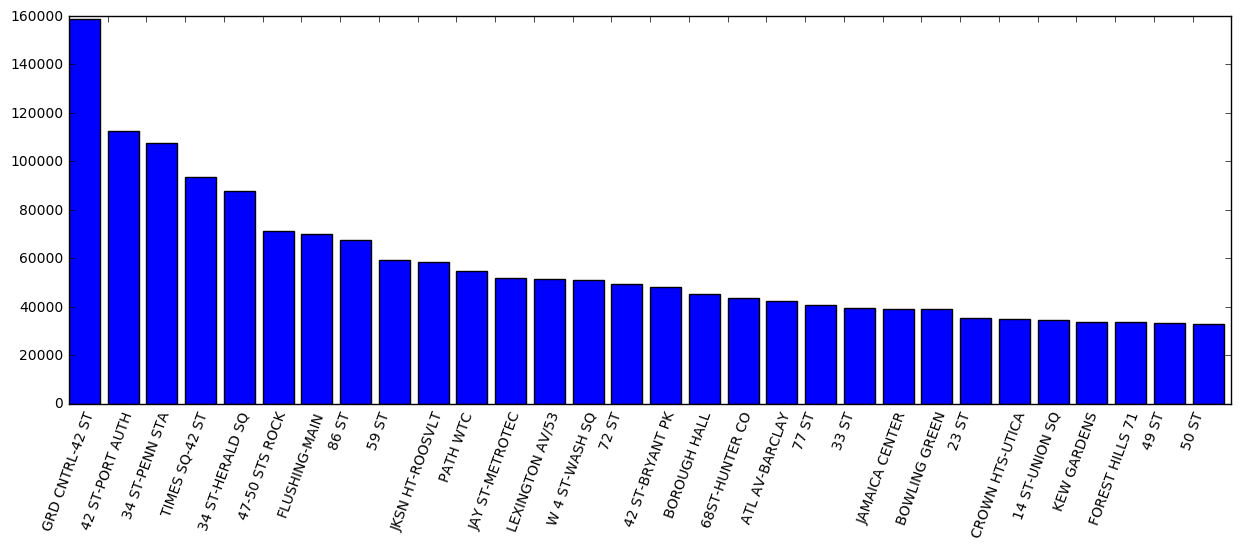

In [149]:
top_stations = traffic_report[:30]
avgs, stations = zip(*top_stations)
indices = range(len(avgs))
plt.figure(figsize=(15,5,))
plt.bar(indices, avgs)
ticks = plt.xticks(indices, stations, rotation = 70)

In [174]:
import pandas as pd

reversed_traffic_report = [reversed(t) for t in traffic_report]
df_to_pickle = pd.DataFrame(reversed_traffic_report, columns=['station', 'avg_daily_traffic_feb'])
df_to_pickle.head()

,station,avg_daily_traffic_feb
0,GRD CNTRL-42 ST,158625
1,42 ST-PORT AUTH,112739
2,34 ST-PENN STA,107514
3,TIMES SQ-42 ST,93595
4,34 ST-HERALD SQ,87825


In [175]:
df_to_pickle.to_pickle('pickle/stations_traffic.p')